대회 및 데이터 파일 주소: https://www.kaggle.com/competitions/ieee-fraud-detection/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import gmean
import xgboost as xgb

c:\users\evfox\appdata\local\programs\python\python38\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load and Merge Dataset

train, test 파일은 각각 transaction과 identity 2개의 파일로 나누어져 있다.

In [2]:
colab = False

In [3]:
path = 'data/'

if colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    path = './drive/My Drive/IEEE-fraud-detection/' + path

    
train_transaction = pd.read_csv(path + 'train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv(path + 'test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv(path + 'train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv(path + 'test_identity.csv', index_col='TransactionID')

In [4]:
train_transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train_transaction.shape

(590540, 393)

In [6]:
train_identity.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [7]:
train_identity.shape

(144233, 40)

두 파일의 column 중 TransactionID만 겹치므로, Transaction ID를 이용해 두 파일을 병합하였다.
row의 수가 다른 걸로 보아 모든 transaction에 대해 identity가 존재하지 않는다는 것을 알 수 있다.

In [8]:
print(test_transaction.shape, test_identity.shape)

(506691, 392) (141907, 40)


In [9]:
train = train_transaction.merge(train_identity, how='left', on='TransactionID')
test = test_transaction.merge(test_identity, how='left', on='TransactionID')

X_train = train.copy()
X_test = test.copy()

del train_transaction, train_identity, test_transaction, test_identity

## EDA

다음은 대회 측에서 제공한 각 column들의 정보 이다. https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203

개인 정보보호를 위해 데이터들이 마스킹 된 상태이다.


TransactionDT: timedelta from a given reference datetime (not an actual timestamp)

TransactionAMT: transaction payment amount in USD

ProductCD: product code, the product for each transaction

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

addr: address

dist: distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.

P_ and (R__) emaildomain: purchaser and recipient email domain

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

D1-D15: timedelta, such as days between previous transaction, etc.

M1-M9: match, such as names on card and address, etc.

Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

In [10]:
train.shape

(590540, 433)

In [11]:
def summary(data, numeric='auto'):
    df = pd.DataFrame()
    df['columns'] = data.columns.values
    df['dtype'] = data.dtypes.values
    df['missing'] = data.isna().sum().values
    df['nunique'] = data.nunique().values
    df['mode'] = data.mode().iloc[0].values
    
    if numeric == 'auto':
        if (df['dtype'] == (float or int)).sum() != len(df):
            numeric = False
    
    if numeric:
        df['mean'] = [data[col].mean() for col in data.columns]
        df['min'] = [data[col].min() for col in data.columns]
        df['q1'] = [data[col].quantile(.25) for col in data.columns]
        df['median'] = [data[col].median() for col in data.columns]
        df['q3'] = [data[col].quantile(.75) for col in data.columns]
        df['max'] = [data[col].max() for col in data.columns]
        

    return df

앞쪽에 위치한 column들을 살펴보면, 결측치가 상당히 많은 column이 있는 걸 확인할 수 있다.

In [12]:
summary(train).head(20)

,columns,dtype,missing,nunique,mode
0,isFraud,int64,0,2,0
1,TransactionDT,int64,0,573349,9474817
2,TransactionAmt,float64,0,20902,59.0
3,ProductCD,object,0,5,W
4,card1,int64,0,13553,7919
5,card2,float64,8933,500,321.0
6,card3,float64,1565,114,150.0
7,card4,object,1577,4,visa
8,card5,float64,4259,119,226.0
9,card6,object,1571,4,debit


In [13]:
train.isna().sum().describe()

count       433.000000
mean     266796.935335
std      215671.252907
min           0.000000
25%        1577.000000
50%      279287.000000
75%      460110.000000
max      585793.000000
dtype: float64

c:\users\evfox\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


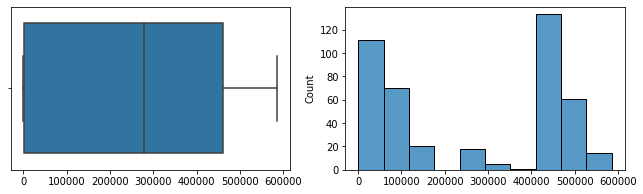

In [14]:
fig, axes = plt.subplots(1,2,figsize=(11,3))
sns.boxplot(train.isna().sum(), ax=axes[0])
sns.histplot(train.isna().sum(), ax=axes[1]);

train 데이터에서 결측치가 존재하지 않는 columns은 20개 미만이다.

In [15]:
train.columns[train.isna().sum() == 0]

Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14'],
      dtype='object')

특이한 점으로, train 데이터에는 결측치가 존재하지만, test 데이터에는 결측치가 존재하지 않는 column들이 많다.

In [16]:
test.columns[test.isna().sum() == 0]

Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'V95', 'V96',
       'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105',
       'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114',
       'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123',
       'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132',
       'V133', 'V134', 'V135', 'V136', 'V137'],
      dtype='object')

TransactionDT: timedelta from a given reference datetime (not an actual timestamp)

TransactionAMT: transaction payment amount in USD

ProductCD: product code, the product for each transaction

In [17]:
summary(train[train.columns[:4]])

,columns,dtype,missing,nunique,mode
0,isFraud,int64,0,2,0
1,TransactionDT,int64,0,573349,9474817
2,TransactionAmt,float64,0,20902,59.0
3,ProductCD,object,0,5,W


train 데이터와 test 데이터의 TransactionDT를 살펴보면, 시간에 기반하여 train test split을 진행한 것을 알 수 있다. 모든 train 데이터는 모든 test 데이터보다 먼저 일어난 거래들로 구성되어 있고, train 데이터와 test 데이터 사이에 약간의 갭이 있다. 분류 모델 학습 시 시간을 고려하여 fold를 나누는 것을 고려해 볼 수 있을 것 같다.

In [18]:
train.index=range(len(train))
test.index=range(len(test))

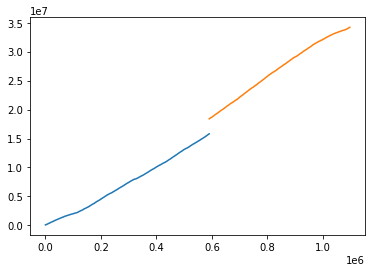

In [19]:
plt.plot(train.index, train['TransactionDT'])
plt.plot(test.index+len(train), test['TransactionDT']);

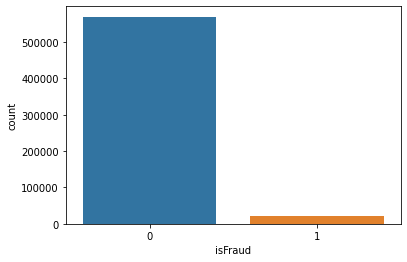

In [20]:
sns.countplot(x='isFraud', data=train);

TransactionDT는 특정 시점으로 부터의 timedelta 값이다.

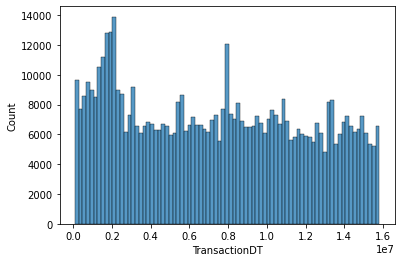

In [21]:
sns.histplot(x='TransactionDT', data=train);

최소값이 86400인 점이 주목할 만 한데, 86400= 24\*60\*60 으로 1일은 86400초로 구성되어 있다. TransactionDT의 단위가 초 라는 가설을 세워볼 수 있다.

In [22]:
train['TransactionDT'].min(), train['TransactionDT'].max()

(86400, 15811131)

만약 TransactionDT의 단위가 초 일시, train, test 데이터는 각각 182일, 183일 간의 데이터로 구성되어 있다. 둘의 합이 정확히 365임으로 보아 총 데이터는 12개월의 데이터를 6달씩 나누었을 것이라 추측할 수 있고, 위에서 언급했듯 train과 test 사이에는 일정 기간의 공백이 있다.

In [23]:
print(
    f' Train length: {(train["TransactionDT"].max() - train["TransactionDT"].min()) / 86400:.2f} Day\n',
    f'Test length: {(test["TransactionDT"].max() - test["TransactionDT"].min()) / 86400:.2f} Day\n',
    f'Gap between Train and Test: {(test["TransactionDT"].min() - train["TransactionDT"].max()) / 86400:.2f} Day'
)

 Train length: 182.00 Day
 Test length: 183.00 Day
 Gap between Train and Test: 30.00 Day


첫 6달이 182일, 그 다음 달이 30일, 그 다음 6달이 183일인 경우는 존재하지 않는다. 만약 하루의 오차를 허용한다면, 다음 2가지 경우가 존재한다.

train/gap/test: 10월\~3월 / 4월 / 5월\~10월 (184일)

train/gap/test: 12월\~5월 / 5월 / 7월\~12월 (184일)

이 중 후자가 맞다고 가정하고 분석을 진행하였는데, 근거는 다음과 같다.

1. 크리스마스 연휴 기간의 거래량이 눈에 띄게 높다.
2. 데이터 파일에 사용자의 OS, 브라우저 버전 정보가 있는데, 해당 버전의 release date를 통해 기간 및 연도를 유추할 수 있다. (이 부분은 대회의 discussion tab을 참조하였다.)

train 데이터는 12월 부터의 데이터 이므로, TransactionDT의 값에 2017-11-30 00:00:00 을 더해서 거래 시각을 구할 수 있다.

In [24]:
import datetime

In [25]:
for data in [train, test]:
    data['TransactionDate'] = data['TransactionDT'].apply(lambda x: datetime.datetime.strptime('2017-11-30', '%Y-%m-%d') + datetime.timedelta(x/86400))

train['TransactionDate']

0        2017-12-01 00:00:00
1        2017-12-01 00:00:01
2        2017-12-01 00:01:09
3        2017-12-01 00:01:39
4        2017-12-01 00:01:46
                 ...        
590535   2018-05-31 23:57:27
590536   2018-05-31 23:57:29
590537   2018-05-31 23:57:59
590538   2018-05-31 23:58:08
590539   2018-05-31 23:58:51
Name: TransactionDate, Length: 590540, dtype: datetime64[ns]

In [26]:
test['TransactionDate']

0        2018-07-01 00:00:24
1        2018-07-01 00:01:03
2        2018-07-01 00:01:50
3        2018-07-01 00:01:50
4        2018-07-01 00:01:57
                 ...        
506686   2018-12-30 23:57:59
506687   2018-12-30 23:58:07
506688   2018-12-30 23:58:46
506689   2018-12-30 23:58:57
506690   2018-12-30 23:59:05
Name: TransactionDate, Length: 506691, dtype: datetime64[ns]

달, 일, 시간, 요일 등의 정보를 추가하였다. 자료가 12월 부터 다음해 11월까지 이므로, 편의상 12월을 0으로 대체하였다.

In [27]:
test['TransactionDate']

0        2018-07-01 00:00:24
1        2018-07-01 00:01:03
2        2018-07-01 00:01:50
3        2018-07-01 00:01:50
4        2018-07-01 00:01:57
                 ...        
506686   2018-12-30 23:57:59
506687   2018-12-30 23:58:07
506688   2018-12-30 23:58:46
506689   2018-12-30 23:58:57
506690   2018-12-30 23:59:05
Name: TransactionDate, Length: 506691, dtype: datetime64[ns]

In [28]:
for data in [train, test]:
    data['TransactionMonth'] = data['TransactionDate'].apply(lambda x: x.month)
    data['TransactionDay'] = data['TransactionDate'].apply(lambda x: x.day)
    data['TransactionHour'] = data['TransactionDate'].apply(lambda x: x.hour)
    data['TransactionWeekday'] = data['TransactionDate'].apply(lambda x: x.weekday())
    
train['TransactionMonth'] = train['TransactionMonth'].replace(12, 0)

거래가 가장 많이 일어난 달은 12월이다.

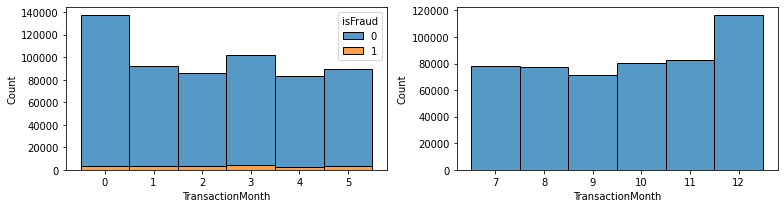

In [29]:
fig, axes = plt.subplots(1,2,figsize=(11,3))
sns.histplot(x='TransactionMonth', hue='isFraud', discrete=True, multiple='stack', data=train, ax=axes[0])
sns.histplot(x='TransactionMonth', discrete=True, multiple='stack', data=test, ax=axes[1])
plt.tight_layout();

train, test 모두 12월 20일 - 25일 사이의 거래가 유독 많다.

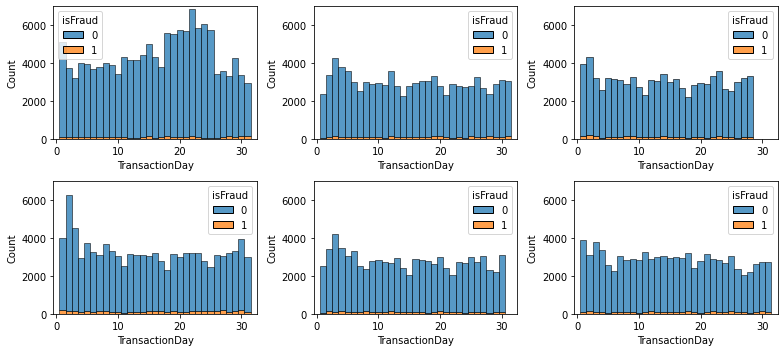

In [30]:
fig, axes = plt.subplots(2,3,figsize=(11,5))

for i in range(6):
    ax = axes[i//3][i%3]
    
    sns.histplot(
        x='TransactionDay', 
        hue='isFraud', 
        discrete=True, 
        multiple='stack', 
        data=train[train['TransactionMonth'] == i], 
        ax=axes[i//3][i%3]
    )
    
    ax.set_xlim(-0.5, 32.5)
    ax.set_ylim(0, 7000)
    
plt.tight_layout();

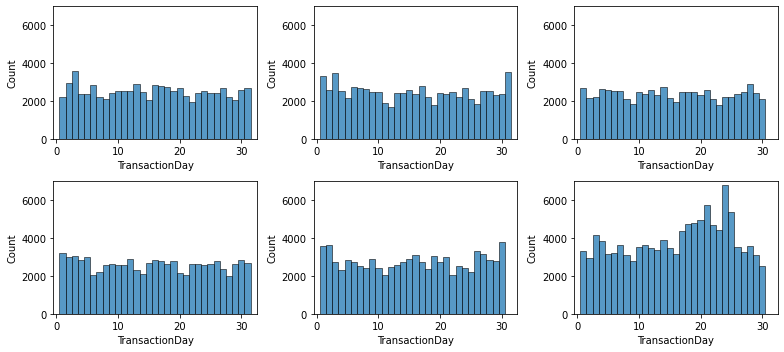

In [31]:
fig, axes = plt.subplots(2,3,figsize=(11,5))

for i in range(6):
    ax = axes[i//3][i%3]
    sns.histplot(
        x='TransactionDay', 
        discrete=True, 
        multiple='stack', 
        data=test[test['TransactionMonth'] == i+7], 
        ax=ax
    )
    
    ax.set_xlim(-0.5, 32.5)
    ax.set_ylim(0, 7000);
    
plt.tight_layout();

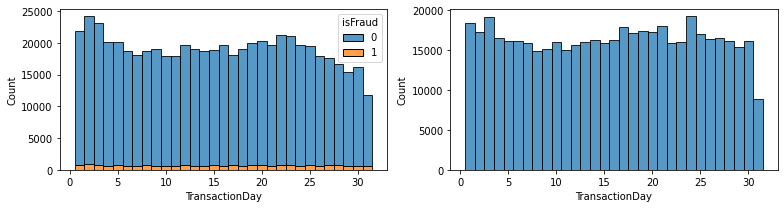

In [32]:
fig, axes = plt.subplots(1,2,figsize=(11,3))
sns.histplot(x='TransactionDay', hue='isFraud', discrete=True, multiple='stack', data=train, ax=axes[0])
sns.histplot(x='TransactionDay', discrete=True, multiple='stack', data=test, ax=axes[1])
plt.tight_layout();

오전 시간대의 거래가 매우 적음을 알 수 있다.

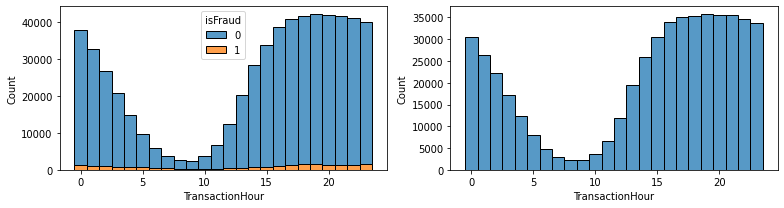

In [33]:
fig, axes = plt.subplots(1,2,figsize=(11,3))
sns.histplot(x='TransactionHour', hue='isFraud', discrete=True, multiple='stack', data=train, ax=axes[0])
sns.histplot(x='TransactionHour', discrete=True, multiple='stack', data=test, ax=axes[1])
plt.tight_layout();

0은 월요일, 6은 일요일이다. 금요일의 거래가 가장 많고, 주말의 거래가 가장 적다.

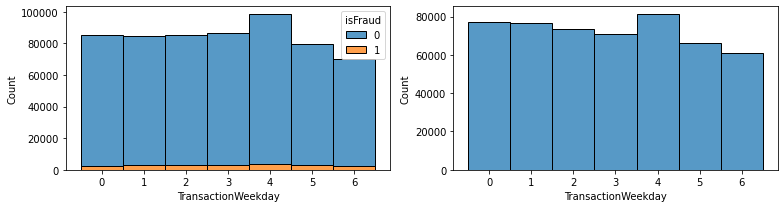

In [34]:
fig, axes = plt.subplots(1,2,figsize=(11,3))
sns.histplot(x='TransactionWeekday', hue='isFraud', discrete=True, multiple='stack', data=train, ax=axes[0])
sns.histplot(x='TransactionWeekday', discrete=True, multiple='stack', data=test, ax=axes[1])
plt.tight_layout();

TransactionAmt는 거래액이다. 대부분의 결제액은 크지 않다.

In [35]:
train['TransactionAmt'].describe()

count    590540.000000
mean        135.027176
std         239.162522
min           0.251000
25%          43.321000
50%          68.769000
75%         125.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

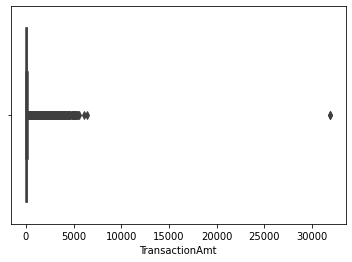

In [36]:
sns.boxplot(x='TransactionAmt', data=train);

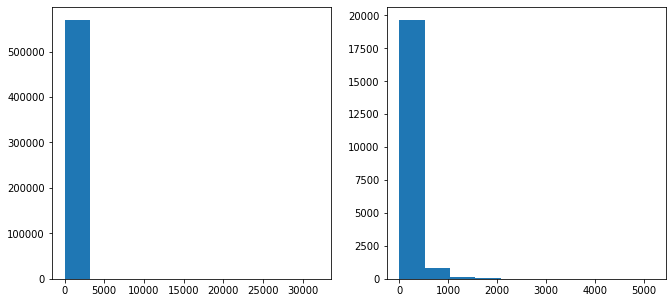

In [37]:
fig, axes = plt.subplots(1,2,figsize=(11,5))
for i in range(2):
    axes[i].hist(train[train['isFraud'] == i]['TransactionAmt']);

그래프로 분간이 어려워 log화 하기로 했다. (모델링 에서는 log함수를 사용하지 않았다)

In [38]:
for data in [train, test]:
    data['TransactionAmtLog'] = data['TransactionAmt'].apply(lambda x: np.log(x+1))

고액의 거래가 사기 비율이 높다.

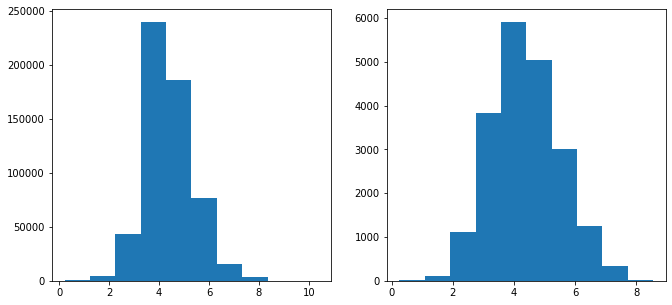

In [39]:
fig, axes = plt.subplots(1,2,figsize=(11,5))
for i in range(2):
    axes[i].hist(train[train['isFraud'] == i]['TransactionAmtLog']);

ProductCD는 상품의 분류이다.

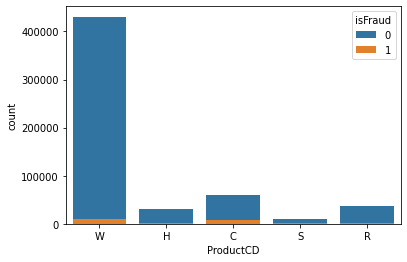

In [40]:
sns.countplot(x='ProductCD', hue='isFraud', dodge=False, data=train);

C의 사기 비율이 높다.

In [41]:
train.groupby('ProductCD').agg('mean')['isFraud']

ProductCD
C    0.116873
H    0.047662
R    0.037826
S    0.058996
W    0.020399
Name: isFraud, dtype: float64

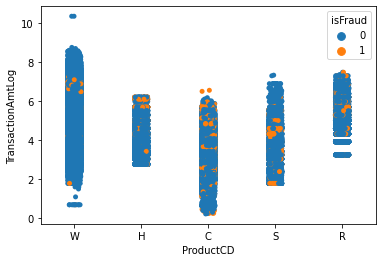

In [42]:
sns.stripplot(x='ProductCD',y='TransactionAmtLog', hue='isFraud', data=train);

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

card1 - card6은 카드 관련 정보이다.

card1만 유일하게 결측값이 없으며, 값이 가장 다양하다.

In [43]:
card_cols = [col for col in train.columns if 'card' in col]

summary(train[card_cols])

,columns,dtype,missing,nunique,mode
0,card1,int64,0,13553,7919
1,card2,float64,8933,500,321.0
2,card3,float64,1565,114,150.0
3,card4,object,1577,4,visa
4,card5,float64,4259,119,226.0
5,card6,object,1571,4,debit


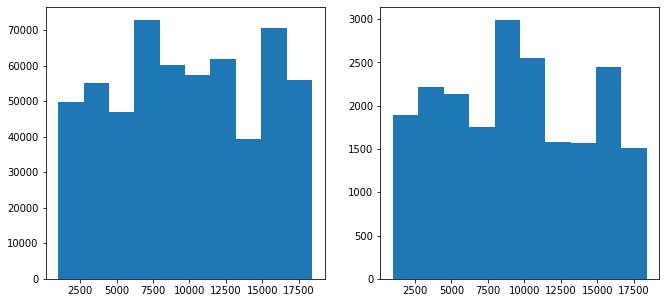

In [44]:
fig, axes = plt.subplots(1,2,figsize=(11,5))
for i in range(2):
    axes[i].hist(train[train['isFraud'] == i]['card1'].fillna(-1));

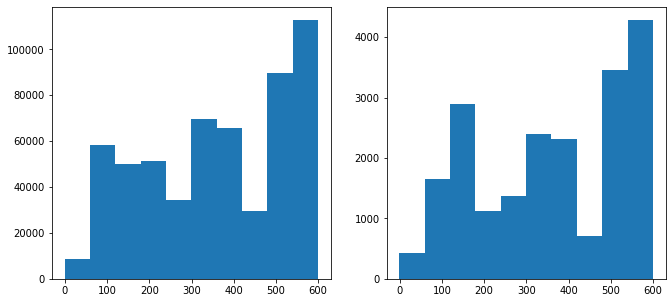

In [45]:
fig, axes = plt.subplots(1,2,figsize=(11,5))
for i in range(2):
    axes[i].hist(train[train['isFraud'] == i]['card2'].fillna(-1));

card3 값이 185인 경우가 유독 사기 비율이 높다.

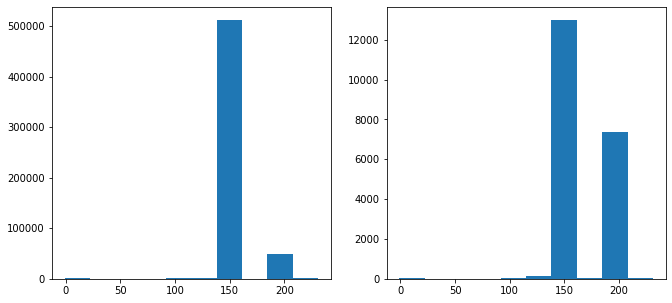

In [46]:
fig, axes = plt.subplots(1,2,figsize=(11,5))
for i in range(2):
    axes[i].hist(train[train['isFraud'] == i]['card3'].fillna(-1));

In [47]:
train[train['isFraud'] == 0]['card3'].value_counts(normalize=True, dropna=False)

150.0    0.892263
185.0    0.085955
106.0    0.002715
NaN      0.002678
146.0    0.002153
           ...   
209.0    0.000002
101.0    0.000002
221.0    0.000002
170.0    0.000002
173.0    0.000002
Name: card3, Length: 107, dtype: float64

In [48]:
train[train['isFraud'] == 1]['card3'].value_counts(normalize=True, dropna=False)

150.0    0.619804
185.0    0.356289
144.0    0.005420
119.0    0.003388
NaN      0.001887
           ...   
215.0    0.000048
197.0    0.000048
132.0    0.000048
166.0    0.000048
224.0    0.000048
Name: card3, Length: 63, dtype: float64

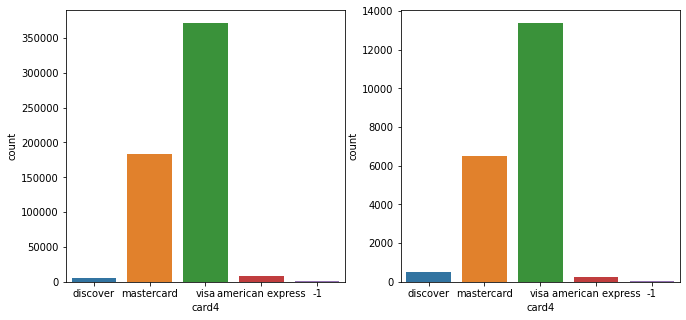

In [49]:
fig, axes = plt.subplots(1,2,figsize=(11,5))
for i in range(2):
    sns.countplot(x=train[train['isFraud'] == i]['card4'].fillna(-1), order=train['card4'].fillna(-1).unique(), ax=axes[i]);

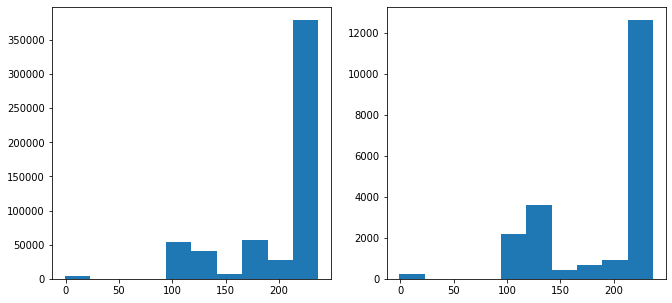

In [50]:
fig, axes = plt.subplots(1,2,figsize=(11,5))
for i in range(2):
    axes[i].hist(train[train['isFraud'] == i]['card5'].fillna(-1));

card6은 카드 종류이며, credit card의 사기 비율이 높다.

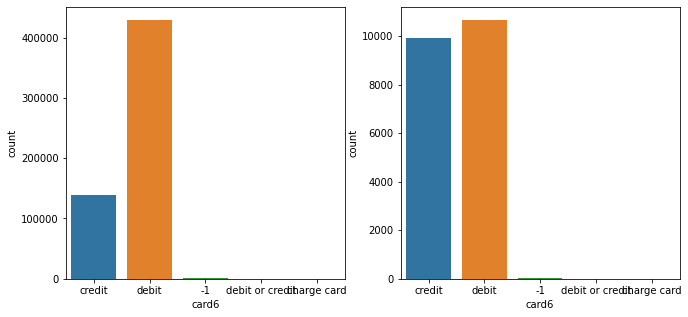

In [51]:
fig, axes = plt.subplots(1,2,figsize=(11,5))
for i in range(2):
    sns.countplot(x=train[train['isFraud'] == i]['card6'].fillna(-1), order=train['card6'].fillna(-1).unique(), ax=axes[i]);

위에서 살펴 보았듯 card1을 제외한 나머지 column들은 결측치가 존재한다. 최빈값으로 대체하거나, 혹은 결측값들을 하나의 항목으로 만드는 방법도 생각해볼 수 있으나, 그 전에 card1을 이용하여 나머지 column들을 추측할 수 있는가 시도해보았다.

card1의 최빈값은 7919이다. card1의 값이 7919일 때 나머지 card column들이 어떻게 분포되어있는지 알아보았다.

In [52]:
train['card1'].value_counts()

7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
         ...  
17084        1
14620        1
11440        1
13231        1
18038        1
Name: card1, Length: 13553, dtype: int64

대부분 결측치를 제외하고는 1가지 값을 가지는 것을 확인할 수 있었다.

In [53]:
train[train['card1'] == 7919]['card2'].value_counts(dropna=False)

194.0    14891
NaN         41
Name: card2, dtype: int64

In [54]:
train[train['card1'] == 7919]['card3'].value_counts(dropna=False)

150.0    14891
NaN         41
Name: card3, dtype: int64

In [55]:
train[train['card1'] == 7919]['card4'].value_counts(dropna=False)

mastercard    14891
NaN              41
Name: card4, dtype: int64

In [56]:
train[train['card1'] == 7919]['card5'].value_counts(dropna=False)

166.0    8844
202.0    6047
NaN        41
Name: card5, dtype: int64

In [57]:
train[train['card1'] == 7919]['card6'].value_counts(dropna=False)

debit    14891
NaN         41
Name: card6, dtype: int64

card1 값을 기준으로 그룹화하여 다른 card column 들이 얼마나 다양한 값을 갖는지 알아보았다. 대부분 결측치를 제외하고는 1가지 종류이고, 많아야 3가지 종류의 였다. card column 들의 결측치에 대해 같은 card1 값을 갖는 row들을 참조하여 채우는 방법을 생각해볼 수 있었다.

In [58]:
train[card_cols].groupby('card1').nunique().describe()

,card2,card3,card4,card5,card6
count,13553.000000,13553.000000,13553.000000,13553.000000,13553.000000
mean,0.995352,1.000812,0.998524,1.008264,1.006788
std,0.204493,0.047821,0.038388,0.166806,0.091466
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,3.000000,2.000000


In [59]:
for card in card_cols[1:]:
    modes = {}

    for value in train['card1'].unique():
        try:
            modes[value] = train[train['card1'] == value][card].mode().values[0]

        except IndexError:
            pass
        
        
    for data in [train, test]:        
        na = set(data['card1'].unique()) - set(modes.keys())

        if len(na) > 0:
            for value in na:
                modes[value] = 'unknown' if data[card].dtype == object else -1

        values = []

        for x, y in zip(data['card1'], data[card]):
            values.append(modes[x] if type(y) == float and np.isnan(y) else y)

        data.loc[:, card] = values


del modes, na, values

addr: address

dist: distance

P_ and (R__) emaildomain: purchaser and recipient email domain

주소, 거리, 이메일 주소 데이터는 전체적으로 결측치가 많다.

In [60]:
summary(train[train.columns[10:16]])

,columns,dtype,missing,nunique,mode
0,addr1,float64,65706,332,299.0
1,addr2,float64,65706,74,87.0
2,dist1,float64,352271,2651,0.0
3,dist2,float64,552913,1751,7.0
4,P_emaildomain,object,94456,59,gmail.com
5,R_emaildomain,object,453249,60,gmail.com


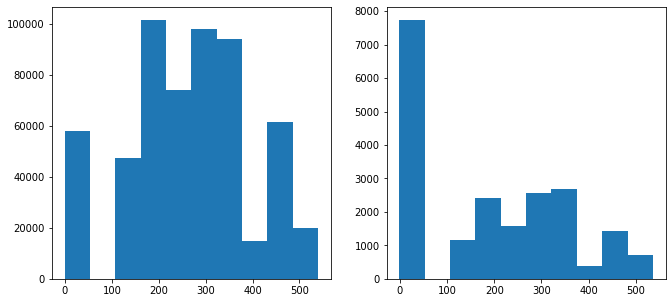

In [61]:
fig, axes = plt.subplots(1,2,figsize=(11,5))
for i in range(2):
    axes[i].hist(train[train['isFraud'] == i]['addr1'].fillna(-1));

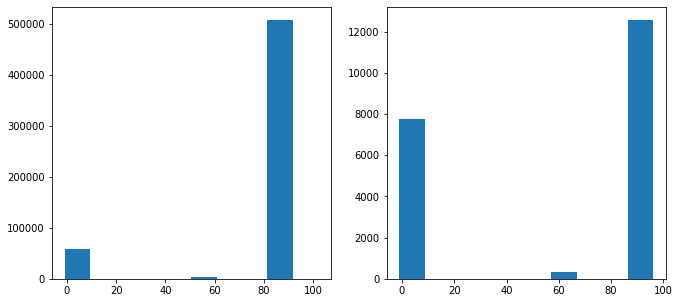

In [62]:
fig, axes = plt.subplots(1,2,figsize=(11,5))
for i in range(2):
    axes[i].hist(train[train['isFraud'] == i]['addr2'].fillna(-1));

addr1, addr2이 결측치인 경우 사기 비율이 매우 높다.

In [63]:
pd.pivot_table(
    data=train[['addr1', 'isFraud']].fillna('NaN'), index='addr1', values='isFraud', aggfunc=['count', 'mean']
).sort_values(by=('count', 'isFraud'), ascending=False).head(10)

,count,mean
,isFraud,isFraud
addr1,,
NaN,65706,0.117813
299.0,46335,0.021258
325.0,42751,0.025426
204.0,42020,0.026654
264.0,39870,0.018259
330.0,26287,0.031955
315.0,23078,0.017809
441.0,20827,0.025592


addr1과 달리 addr2는 값이 다양하지 않다.

In [64]:
pd.pivot_table(
    data=train[['addr2', 'isFraud']].fillna('NaN'), index='addr2', values='isFraud', aggfunc=['count', 'mean']
).sort_values(by=('count', 'isFraud'), ascending=False).head(10)

,count,mean
,isFraud,isFraud
addr2,,
87.0,520481,0.023972
NaN,65706,0.117813
60.0,3084,0.090467
96.0,638,0.139498
32.0,91,0.065934
65.0,82,0.536585
16.0,55,0.000000
31.0,47,0.000000


dist1, dist2 모두 이상치가 많다.

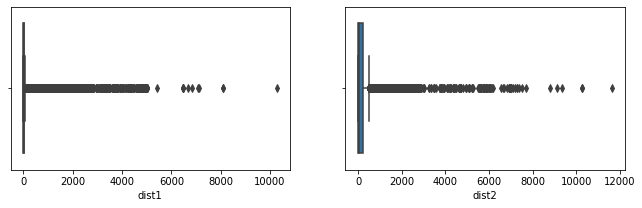

In [65]:
fig, axes = plt.subplots(1,2,figsize=(11,3))
sns.boxplot(x='dist1', data=train, ax=axes[0])
sns.boxplot(x='dist2', data=train, ax=axes[1]);

특이한 점으로, dist1과 dist2가 모두 nan인 경우는 존재하지 않았다. 반드시 적어도 둘 중 하나의 값은 존재한다.

In [66]:
train[['dist1', 'dist2']].isna().value_counts(normalize=True) 

dist1  dist2
True   True     0.532807
False  True     0.403476
True   False    0.063716
dtype: float64

In [67]:
train[['dist1', 'dist2']].describe()

,dist1,dist2
count,238269.000000,37627.000000
mean,118.502180,231.855423
std,371.872026,529.053494
min,0.000000,0.000000
25%,3.000000,7.000000
50%,8.000000,37.000000
75%,24.000000,206.000000
max,10286.000000,11623.000000


In [68]:
for data in [train, test]:
    data['dist1Log'] = data['dist1'].apply(lambda x: x if np.isnan(x) else np.log(x+1))
    data['dist2Log'] = data['dist2'].apply(lambda x: x if np.isnan(x) else np.log(x+1))

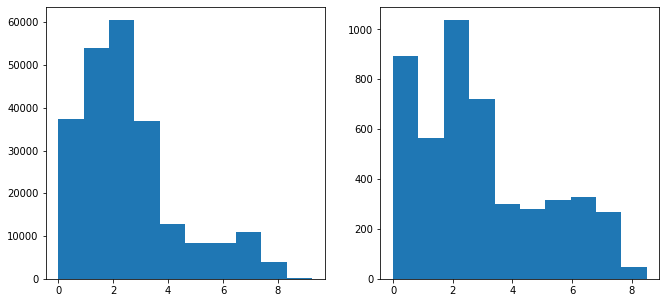

In [69]:
fig, axes = plt.subplots(1,2,figsize=(11,5))
for i in range(2):
    axes[i].hist(train[train['isFraud'] == i]['dist1Log']);

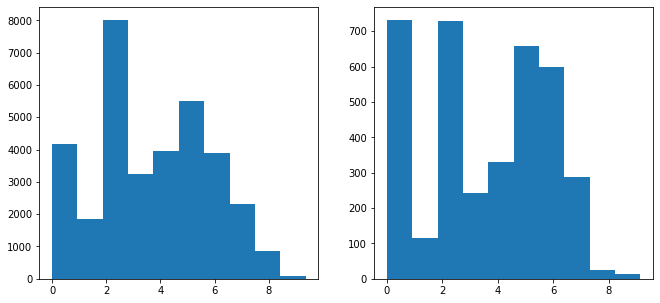

In [70]:
fig, axes = plt.subplots(1,2,figsize=(11,5))
for i in range(2):
    axes[i].hist(train[train['isFraud'] == i]['dist2Log']);

구매자 이메일 주소에 비해 판매자 이메일 주소는 결측값이 많다.

In [71]:
train[[col for col in train.columns if 'email' in col]].isna().sum() / len(train)

P_emaildomain    0.159949
R_emaildomain    0.767516
dtype: float64

In [72]:
train['P_emaildomain'].value_counts(normalize=True, dropna=False).head(10)

gmail.com        0.386688
yahoo.com        0.170918
NaN              0.159949
hotmail.com      0.076625
anonymous.com    0.062651
aol.com          0.047904
comcast.net      0.013357
icloud.com       0.010612
outlook.com      0.008629
msn.com          0.006929
Name: P_emaildomain, dtype: float64

In [73]:
for data in [train, test]:
    data['P_emaildomain'].fillna('unknown', inplace=True)

구매자 도메인 유형 별 사기 비율을 살펴보면 protonmail의 사기 비율이 매우 높음을 확인할 수 있다.

In [74]:
pd.pivot_table(
    data=train, index='P_emaildomain', values='isFraud', aggfunc=['count', 'mean']
).sort_values(by=('mean', 'isFraud'), ascending=False).head(10)

,count,mean
,isFraud,isFraud
P_emaildomain,,
protonmail.com,76,0.407895
mail.com,559,0.189624
outlook.es,438,0.130137
aim.com,315,0.126984
outlook.com,5096,0.094584
hotmail.es,305,0.065574
live.com.mx,749,0.054740
hotmail.com,45250,0.052950


In [75]:
train['R_emaildomain'].value_counts(normalize=True, dropna=False).head(10)

NaN              0.767516
gmail.com        0.096771
hotmail.com      0.046583
anonymous.com    0.034763
yahoo.com        0.020053
aol.com          0.006267
outlook.com      0.004245
comcast.net      0.003068
yahoo.com.mx     0.002554
icloud.com       0.002367
Name: R_emaildomain, dtype: float64

In [76]:
for data in [train, test]:
    data['R_emaildomain'].fillna('unknown', inplace=True)

판매자도 마찬가지로 protonmail의 사기 비율이 매우 높다.

In [77]:
pd.pivot_table(
    data=train, index='R_emaildomain', values='isFraud', aggfunc=['count', 'mean']
).sort_values(by=('mean', 'isFraud'), ascending=False).head(10)

,count,mean
,isFraud,isFraud
R_emaildomain,,
protonmail.com,41,0.951220
mail.com,122,0.377049
netzero.net,9,0.222222
outlook.com,2507,0.165138
outlook.es,433,0.131640
icloud.com,1398,0.128755
gmail.com,57147,0.119184
hotmail.com,27509,0.077793


C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

C column들은 카드와 관련된 데이터 이며 정확한 의미는 알 수 없다.
train 데이터의 C column은 결측값이 존재하지 않으며, 모두 최소값이 0이고 대부분 3분위수가 3 이하이나 최대값은 그에 비해 매우 큰 편이다.

train 데이터와는 달리 test 데이터에는 약간의 결측값이 존재한다.

In [78]:
c_cols = [f'C{i}' for i in range(1,15)]
summary(train[c_cols])

,columns,dtype,missing,nunique,mode,mean,min,q1,median,q3,max
0,C1,float64,0,1657,1.0,14.092458,0.0,1.0,1.0,3.0,4685.0
1,C2,float64,0,1216,1.0,15.269734,0.0,1.0,1.0,3.0,5691.0
2,C3,float64,0,27,0.0,0.005644,0.0,0.0,0.0,0.0,26.0
3,C4,float64,0,1260,0.0,4.092185,0.0,0.0,0.0,0.0,2253.0
4,C5,float64,0,319,0.0,5.571526,0.0,0.0,0.0,1.0,349.0
5,C6,float64,0,1328,1.0,9.071082,0.0,1.0,1.0,2.0,2253.0
6,C7,float64,0,1103,0.0,2.848478,0.0,0.0,0.0,0.0,2255.0
7,C8,float64,0,1253,0.0,5.144574,0.0,0.0,0.0,0.0,3331.0
8,C9,float64,0,205,1.0,4.480240,0.0,0.0,1.0,2.0,210.0
9,C10,float64,0,1231,0.0,5.240343,0.0,0.0,0.0,0.0,3257.0


In [79]:
summary(test[c_cols])

,columns,dtype,missing,nunique,mode,mean,min,q1,median,q3,max
0,C1,float64,3,1174,1.0,10.093211,0.0,1.0,1.0,3.0,2950.0
1,C2,float64,3,1123,1.0,10.714635,0.0,1.0,1.0,3.0,3275.0
2,C3,float64,3,31,0.0,0.027403,0.0,0.0,0.0,0.0,31.0
3,C4,float64,3,728,0.0,2.385875,0.0,0.0,0.0,1.0,1601.0
4,C5,float64,3,353,0.0,4.962701,0.0,0.0,0.0,1.0,376.0
5,C6,float64,3,834,1.0,6.854992,0.0,1.0,1.0,2.0,1601.0
6,C7,float64,3,518,0.0,1.678173,0.0,0.0,0.0,0.0,1621.0
7,C8,float64,3,442,0.0,1.893994,0.0,0.0,0.0,1.0,1005.0
8,C9,float64,3,354,1.0,4.611943,0.0,0.0,1.0,2.0,572.0
9,C10,float64,3,456,0.0,1.810149,0.0,0.0,0.0,1.0,881.0


모든 자료는 정수로 이루어져 있다.

In [80]:
(train[c_cols] % 1).sum()

C1     0.0
C2     0.0
C3     0.0
C4     0.0
C5     0.0
C6     0.0
C7     0.0
C8     0.0
C9     0.0
C10    0.0
C11    0.0
C12    0.0
C13    0.0
C14    0.0
dtype: float64

In [81]:
(test[c_cols] % 1).sum()

C1     0.0
C2     0.0
C3     0.0
C4     0.0
C5     0.0
C6     0.0
C7     0.0
C8     0.0
C9     0.0
C10    0.0
C11    0.0
C12    0.0
C13    0.0
C14    0.0
dtype: float64

각 column들 간에 상관관계가 있는지 correlation analysis를 해보았다. Spearman 상관계수를 사용하였는데, 그 이유는 C column 들이 정규분포를 따르지 않고, 연속형 자료가 아니며, 이상치가 많기 때문에 Pearson 상관계수를 사용하는 것은 적합하지 않다고 생각했기 때문이다. Pearson 상관계수를 사용할 경우 매우 다른 결과가 나온다.

일부 column들 간에 강한 상관관계가 있다.

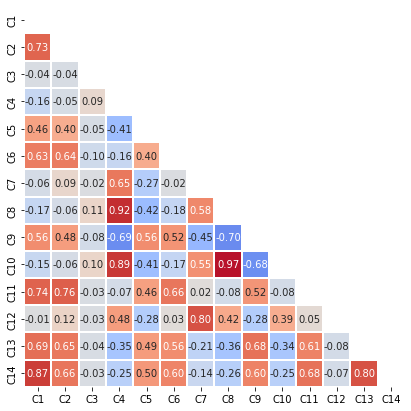

In [82]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
corr = train[c_cols].corr('spearman')
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cbar=False, annot=True, square=True, linewidth=.1, fmt='.2f', cmap='coolwarm', ax=ax);

D1-D15: timedelta, such as days between previous transaction, etc.

D column은 시간과 관련된 정보들이다.

눈에 띄는 점으로, D9는 고유한 값이 24개이고 0부터 1 사이의 값을 가진다. 특정 값을 min max scale 한 것으로 추정된다.

그리고 D8과 D9는 결측치의 수가 같으며, 전혀 유사하지 않은 분포를 가지는데 최빈값은 동일하다. D8은 다른 column들에 비해 유독 unique한 값들의 개수가 많은 편이다.

In [83]:
d_cols = [f'D{i}' for i in range(1,16)]
summary(train[d_cols])

,columns,dtype,missing,nunique,mode,mean,min,q1,median,q3,max
0,D1,float64,1269,641,0.000000,94.347568,0.0,0.000000,3.000000,122.000000,640.000000
1,D2,float64,280797,641,0.000000,169.563231,0.0,26.000000,97.000000,276.000000,640.000000
2,D3,float64,262878,649,0.000000,28.343348,0.0,1.000000,8.000000,27.000000,819.000000
3,D4,float64,168922,808,0.000000,140.002441,-122.0,0.000000,26.000000,253.000000,869.000000
4,D5,float64,309841,688,0.000000,42.335965,0.0,1.000000,10.000000,32.000000,819.000000
5,D6,float64,517353,829,0.000000,69.805717,-83.0,0.000000,0.000000,40.000000,873.000000
6,D7,float64,551623,597,0.000000,41.638950,0.0,0.000000,0.000000,17.000000,843.000000
7,D8,float64,515614,12353,0.791666,146.058108,0.0,0.958333,37.875000,187.958328,1707.791626
8,D9,float64,515614,24,0.791666,0.561057,0.0,0.208333,0.666666,0.833333,0.958333
9,D10,float64,76022,818,0.000000,123.982137,0.0,0.000000,15.000000,197.000000,876.000000


D column들은 시간과 관련된 column들인 만큼, correlation analysis에 TransactionDate와 관련된 column들도 추가하였다. D column 들 간에 매우 높은 상관관계를 보이는 일부 column 들이 보인다. 특이한 점으로, D9과 TransactionHour의 상관계수가 1.0을 기록했다.

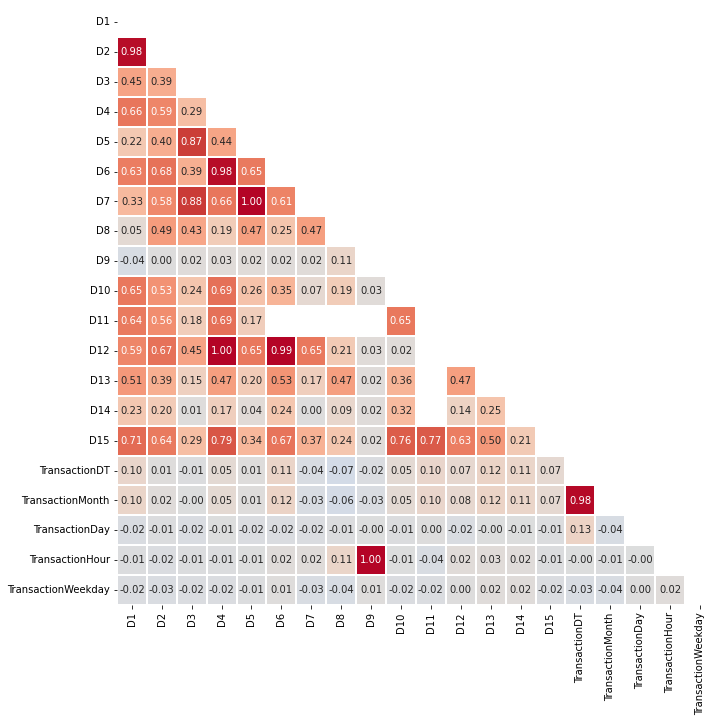

In [84]:
transaction_cols = ['TransactionDT', 'TransactionMonth', 'TransactionDay', 'TransactionHour', 'TransactionWeekday']

fig, ax = plt.subplots(1,1,figsize=(11,11))
corr = train[d_cols+transaction_cols].corr('spearman')
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cbar=False, annot=True, square=True, linewidth=.1, fmt='.2f', cmap='coolwarm', ax=ax);

산점도를 통해 D column과 Transaction column 간의 관계를 더 살펴보기로 했다.

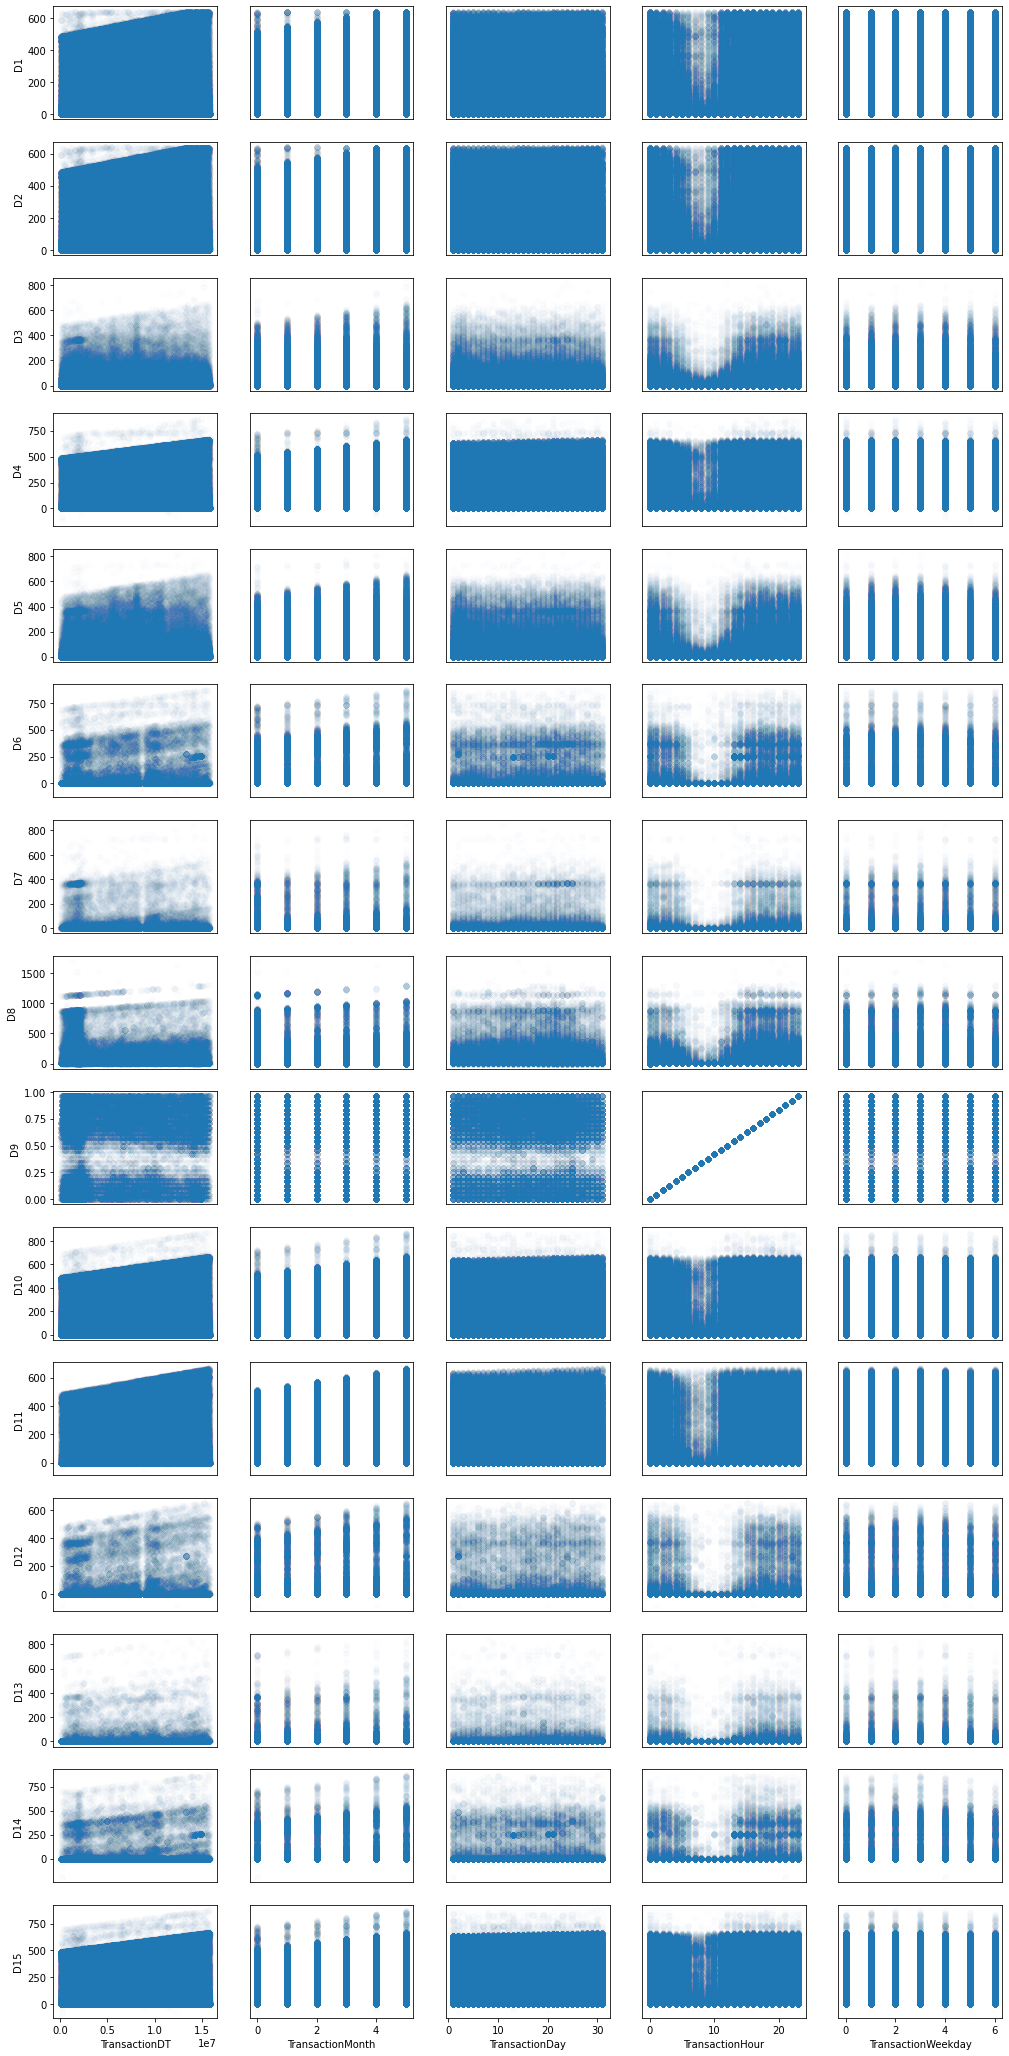

In [85]:
fig, axes = plt.subplots(15,5, figsize=(17,37))

for i in range(15):
    for j, col in enumerate(transaction_cols):
        ax=axes[i][j]
        sns.scatterplot(x=col, y=f'D{i+1}', edgecolor=None, alpha=.01, data=train, ax=ax)
        
        if j > 0:
            ax.set_yticks([])
            ax.set_ylabel('')
        
        if i < 14:
            ax.set_xticks([])
            ax.set_xlabel('')

TransactionHour와 D9이 완벽하게 일치하는 것을 알 수 있다. D9과 달리 TransactionHour는 결측값이 없으므로, TransactionHour로 D9을 대체할 수 있을 것 같다.

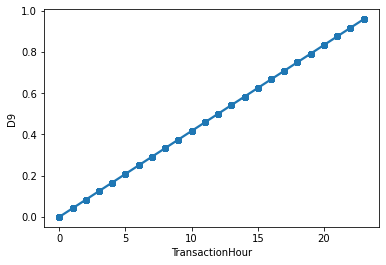

In [86]:
sns.regplot(x='TransactionHour', y='D9', data=train);

M1-M9: match, such as names on card and address, etc.

M column은 M4를 제외하고는 전부 True/False 로 구성되어 있다.

In [87]:
m_cols = [f'M{i}' for i in range(1,10)]
summary(train[m_cols])

,columns,dtype,missing,nunique,mode
0,M1,object,271100,2,T
1,M2,object,271100,2,T
2,M3,object,271100,2,T
3,M4,object,281444,3,M0
4,M5,object,350482,2,F
5,M6,object,169360,2,F
6,M7,object,346265,2,F
7,M8,object,346252,2,F
8,M9,object,346252,2,T


In [88]:
train['M4'].value_counts()

M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64

In [89]:
for data in [train, test]:
    for col in m_cols:
        if col != 'M4':
            data[col] = data[col].map({'T':1, 'F':0})

        else:
            data[col] = data[col].map({'M0':0, 'M1':1, 'M2':2})

In [90]:
#for data in [train, test]:
#    data[m_cols] = data[m_cols].fillna(-1)

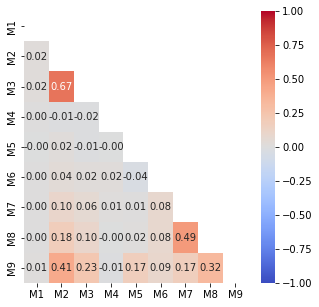

In [91]:
corr = train[m_cols].corr('spearman')

fig = plt.figure(figsize=(5,5))
mask = np.triu(np.ones_like(corr))
ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='coolwarm')

Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

V column 들은 카드사에서 산출한 지표들이다. 총 339개의 column으로 구성되어 있어 전부 살펴보기는 어렵다.

In [92]:
v_cols = [f'V{i}' for i in range(1,340)]

In [93]:
train[v_cols].dtypes.value_counts()

float64    339
dtype: int64

In [94]:
train[v_cols].min().describe()

count    339.000000
mean       0.020649
std        0.142416
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
dtype: float64

In [95]:
train[v_cols].max().describe()

count       339.000000
mean      20094.862089
std       52774.265429
min           1.000000
25%           9.000000
50%          31.000000
75%         975.500000
max      641511.437500
dtype: float64

In [96]:
train[v_cols].mean().describe()

count      339.000000
mean       194.677363
std       2585.488392
min          0.000534
25%          0.370876
50%          1.013279
75%          4.856475
max      47453.181173
dtype: float64

In [97]:
train[v_cols].nunique().describe()

count      339.000000
mean      1550.631268
std       4072.814653
min          2.000000
25%          9.500000
50%         32.000000
75%        870.000000
max      37367.000000
dtype: float64

결측치가 상당히 많다.

In [98]:
train[v_cols].isna().sum().describe()

count       339.000000
mean     254159.374631
std      211886.118667
min          12.000000
25%        1269.000000
50%      279287.000000
75%      460110.000000
max      508595.000000
dtype: float64

특이한 점으로 결측치 수가 같은 column들이 많다.

In [99]:
isna = train[v_cols].isna().sum()
isna

V1      279287
V2      279287
V3      279287
V4      279287
V5      279287
         ...  
V335    508189
V336    508189
V337    508189
V338    508189
V339    508189
Length: 339, dtype: int64

총 339개의 column 들이 갖는 결측치는 총 15가지 이다.

In [100]:
na_dict = {}

for value in isna.unique():
    na_dict[value] = isna[isna == value].keys().to_list()
    
pd.DataFrame(na_dict.items(), index=None)

,0,1
0,279287,"[V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11]"
1,76073,"[V12, V13, V14, V15, V16, V17, V18, V19, V20, ..."
2,168969,"[V35, V36, V37, V38, V39, V40, V41, V42, V43, ..."
3,77096,"[V53, V54, V55, V56, V57, V58, V59, V60, V61, ..."
4,89164,"[V75, V76, V77, V78, V79, V80, V81, V82, V83, ..."
5,314,"[V95, V96, V97, V98, V99, V100, V101, V102, V1..."
6,508595,"[V138, V139, V140, V141, V142, V146, V147, V14..."
7,508589,"[V143, V144, V145, V150, V151, V152, V159, V16..."
8,450909,"[V167, V168, V172, V173, V176, V177, V178, V17..."
9,450721,"[V169, V170, V171, V174, V175, V180, V184, V18..."


V1 부터 V11은 결측치의 수가 같으며, 0 이상의 정수로 구성되어 있다.

In [101]:
summary(train[list(na_dict.values())[0]])

,columns,dtype,missing,nunique,mode,mean,min,q1,median,q3,max
0,V1,float64,279287,2,1.0,0.999945,0.0,1.0,1.0,1.0,1.0
1,V2,float64,279287,9,1.0,1.045204,0.0,1.0,1.0,1.0,8.0
2,V3,float64,279287,10,1.0,1.078075,0.0,1.0,1.0,1.0,9.0
3,V4,float64,279287,7,1.0,0.846456,0.0,1.0,1.0,1.0,6.0
4,V5,float64,279287,7,1.0,0.876991,0.0,1.0,1.0,1.0,6.0
5,V6,float64,279287,10,1.0,1.045686,0.0,1.0,1.0,1.0,9.0
6,V7,float64,279287,10,1.0,1.072870,0.0,1.0,1.0,1.0,9.0
7,V8,float64,279287,9,1.0,1.027704,0.0,1.0,1.0,1.0,8.0
8,V9,float64,279287,9,1.0,1.041529,0.0,1.0,1.0,1.0,8.0
9,V10,float64,279287,5,0.0,0.463915,0.0,0.0,0.0,1.0,4.0


일부 column들 간에 높은 상관관계가 있는 걸 확인할 수 있다. feature selection 시 상관계수를 이용해 일부 column을 삭제하는 방법을 생각해볼 수 있을 것 같다.

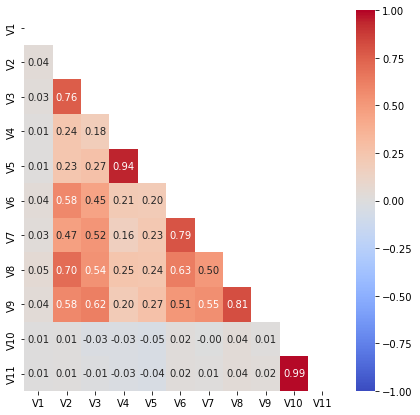

In [102]:
corr = train[list(na_dict.values())[0]].corr('spearman')

fig, ax = plt.subplots(figsize=(7,7))
mask = np.triu(np.ones_like(corr))
ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='coolwarm')

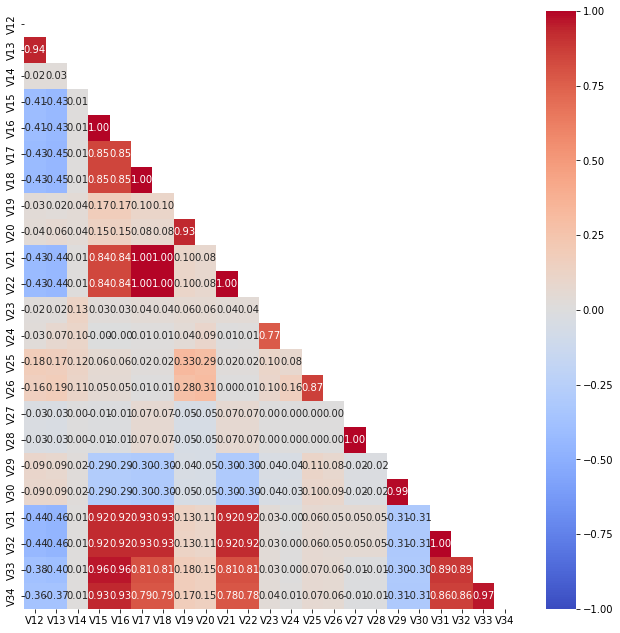

In [103]:
corr = train[list(na_dict.values())[1]].corr('spearman')

fig, ax = plt.subplots(figsize=(11,11))
mask = np.triu(np.ones_like(corr))
ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='coolwarm')

Identity column에는 다양한 형태의 데이터들이 포함되어 있다.

In [104]:
id_cols = [col for col in train.columns if 'id' in col]
summary(train[id_cols])

,columns,dtype,missing,nunique,mode
0,id_01,float64,446307,77,-5.0
1,id_02,float64,449668,115655,1102.0
2,id_03,float64,524216,24,0.0
3,id_04,float64,524216,15,0.0
4,id_05,float64,453675,93,0.0
5,id_06,float64,453675,101,0.0
6,id_07,float64,585385,84,0.0
7,id_08,float64,585385,94,-100.0
8,id_09,float64,515614,46,0.0
9,id_10,float64,515614,62,0.0


train 데이터와 test 데이터의 column명이 일치하지 않아 수정하였다.

In [105]:
test.rename(
    dict(zip([col for col in test.columns if 'id' in col], id_cols)), 
    axis=1, 
    inplace=True
)

In [106]:
id_cols_float = [col for col in id_cols if train[col].dtype == float]
id_cols_object = [col for col in id_cols if train[col].dtype == object]

summary(train[id_cols_float])

,columns,dtype,missing,nunique,mode,mean,min,q1,median,q3,max
0,id_01,float64,446307,77,-5.0,-10.170502,-100.0,-10.0,-5.0,-5.0,0.0
1,id_02,float64,449668,115655,1102.0,174716.584708,1.0,67992.0,125800.5,228749.0,999595.0
2,id_03,float64,524216,24,0.0,0.060189,-13.0,0.0,0.0,0.0,10.0
3,id_04,float64,524216,15,0.0,-0.058938,-28.0,0.0,0.0,0.0,0.0
4,id_05,float64,453675,93,0.0,1.615585,-72.0,0.0,0.0,1.0,52.0
5,id_06,float64,453675,101,0.0,-6.698710,-100.0,-6.0,0.0,0.0,0.0
6,id_07,float64,585385,84,0.0,13.285354,-46.0,5.0,14.0,22.0,61.0
7,id_08,float64,585385,94,-100.0,-38.600388,-100.0,-48.0,-34.0,-23.0,0.0
8,id_09,float64,515614,46,0.0,0.091023,-36.0,0.0,0.0,0.0,25.0
9,id_10,float64,515614,62,0.0,-0.301124,-100.0,0.0,0.0,0.0,0.0


id_11을 제외한 column들은 전부 정수로 이루어져 있다.

In [107]:
(train[id_cols_float] % 1).sum() == 0

id_01     True
id_02     True
id_03     True
id_04     True
id_05     True
id_06     True
id_07     True
id_08     True
id_09     True
id_10     True
id_11    False
id_13     True
id_14     True
id_17     True
id_18     True
id_19     True
id_20     True
id_21     True
id_22     True
id_24     True
id_25     True
id_26     True
id_32     True
dtype: bool

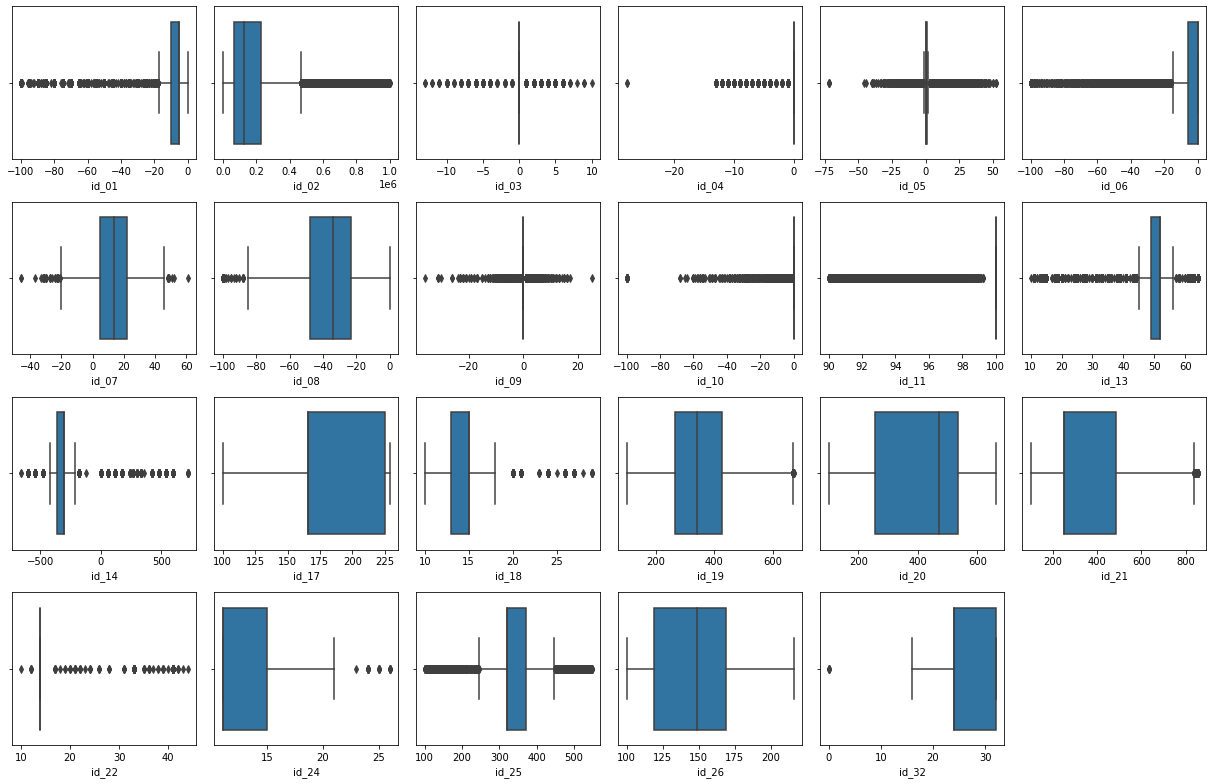

In [108]:
fig, axes = plt.subplots(4,6, figsize=(17,11))

for i in range(4):
    for j in range(6):
        if i*6+j < 23:
            sns.boxplot(x=id_cols_float[i*6+j], data=train, ax=axes[i][j])
        else:
            axes[i][j].axis('off')
        
plt.tight_layout();

다양한 형태의 문자열 데이터들이 존재한다.

In [109]:
for col in id_cols_object:
    display(train[col].value_counts(dropna=False))

NaN         446307
NotFound    123025
Found        21208
Name: id_12, dtype: int64

NaN        449555
Found       67728
New         61612
Unknown     11645
Name: id_15, dtype: int64

NaN         461200
Found        66324
NotFound     63016
Name: id_16, dtype: int64

NaN                     585371
IP_PROXY:TRANSPARENT      3489
IP_PROXY:ANONYMOUS        1071
IP_PROXY:HIDDEN            609
Name: id_23, dtype: int64

NaN         585371
Found         5155
NotFound        14
Name: id_27, dtype: int64

NaN      449562
Found     76232
New       64746
Name: id_28, dtype: int64

NaN         449562
Found        74926
NotFound     66052
Name: id_29, dtype: int64

NaN                 512975
Windows 10           21155
Windows 7            13110
iOS 11.2.1            3722
iOS 11.1.2            3699
                     ...  
func                    10
iOS 11.4.0               5
Mac OS X 10_13_5         4
Windows                  3
iOS 11.4.1               1
Name: id_30, Length: 76, dtype: int64

NaN                        450258
chrome 63.0                 22000
mobile safari 11.0          13423
mobile safari generic       11474
ie 11.0 for desktop          9030
                            ...  
LG/K-200                        1
chromium                        1
iron                            1
M4Tel/M4                        1
chrome 67.0 for android         1
Name: id_31, Length: 131, dtype: int64

NaN          517251
1920x1080     16874
1366x768       8605
1334x750       6447
2208x1242      4900
              ...  
1536x960          1
1232x800          1
1264x924          1
1281x800          1
1280x900          1
Name: id_33, Length: 261, dtype: int64

NaN                512735
match_status:2      60011
match_status:1      17376
match_status:0        415
match_status:-1         3
Name: id_34, dtype: int64

NaN    449555
T       77814
F       63171
Name: id_35, dtype: int64

NaN    449555
F      134066
T        6919
Name: id_36, dtype: int64

NaN    449555
T      110452
F       30533
Name: id_37, dtype: int64

NaN    449555
F       73922
T       67063
Name: id_38, dtype: int64

Found/Not Found 혹은 True/False 등은 label encoding하는데 별 어려움이 없을거 같으니 그 외의 column들 위주로 살펴보기로 했다.

id_30은 기기의 운영체제 및 버전을 나타내는 것 같다.

In [110]:
pd.pivot_table(
    data=train, index='id_30', values='isFraud', aggfunc=['count', 'mean']
).sort_values(by=('count', 'isFraud'), ascending=False).head(20)

,count,mean
,isFraud,isFraud
id_30,,
Windows 10,21155,0.031056
Windows 7,13110,0.032952
iOS 11.2.1,3722,0.049167
iOS 11.1.2,3699,0.035145
Android 7.0,2871,0.057820
Mac OS X 10_12_6,2559,0.014068
Mac OS X 10_11_6,2348,0.012351
iOS 11.3.0,2016,0.068452


운영체제 종류 별로 묶으면 다음과 같다.

In [111]:
kws = ['Windows', 'iOS', 'Android', 'Mac']

for kw in kws:
    train.loc[train['id_30'].str.contains(kw, na=False), 'id_30'] = kw

In [112]:
pd.pivot_table(
    data=train, index='id_30', values='isFraud', aggfunc=['count', 'mean']
).sort_values(by=('count', 'isFraud'), ascending=False).head(20)

,count,mean
,isFraud,isFraud
id_30,,
Windows,36739,0.034514
iOS,19782,0.062683
Mac,13580,0.021944
Android,6303,0.085991
Linux,1136,0.074824
other,15,0.600000
func,10,0.000000


id_31은 브라우저 종류 및 버전을 나타내는 것 같다. 같은 브라우저 끼리도 버전에 따라 사기 비율 차이가 큰 편이라, 같은 종류의 브라우저끼리 묶어서 보는 것이 나을지는 고민해볼 필요가 있다.

In [113]:
pd.pivot_table(
    data=train, index='id_31', values='isFraud', aggfunc=['count', 'mean']
).sort_values(by=('count', 'isFraud'), ascending=False).head(20)

,count,mean
,isFraud,isFraud
id_31,,
chrome 63.0,22000,0.068318
mobile safari 11.0,13423,0.062728
mobile safari generic,11474,0.099878
ie 11.0 for desktop,9030,0.019380
safari generic,8195,0.025015
chrome 62.0,7182,0.041632
chrome 65.0,6871,0.098821
chrome 64.0,6711,0.091641


In [114]:
kws = {
    'chrome':'Chrome', 'safari':'Safari', 'ie':'IE', 'edge':'Edge', 'firefox':'Firefox', 'Firefox':'Firefox', 'opera':'Opera', 
    'samsung':'Samsung', 'Samsung':'Samsung', 'google':'Google', 'android':'Android', 'Android':'Android'
}

for key, value in kws.items():
    train.loc[train['id_31'].str.contains(key, na=False), 'id_31'] = value

    
train.loc[train['id_31'].isin(train['id_31'].value_counts()[train['id_31'].value_counts() < 100].index), 'id_31'] = 'other'

In [115]:
pd.pivot_table(
    data=train, index='id_31', values='isFraud', aggfunc=['count', 'mean']
).sort_values(by=('count', 'isFraud'), ascending=False).head(20)

,count,mean
,isFraud,isFraud
id_31,,
Chrome,76059,0.095952
Safari,37281,0.063947
IE,10018,0.025454
Firefox,7017,0.078809
Edge,6401,0.035151
Samsung,2247,0.087227
Opera,449,0.316258
other,425,0.181176


id_33은 기기의 해상도 이다. 해당 정보를 실수형 자료로 바꾸는 방법에 대해 생각해봤는데, 다음과 같은 방법이 있는 것 같다.

1. 가로와 세로를 각각 별개의 column으로 분리 (예: 1920x1080 -> 1920, 1080)
2. 총 픽셀의 수(가로와 세로의 곱)를 사용, 필요에 따라 화면 비율도 새로운 column으로 추가 가능
3. label encoding

In [116]:
pd.pivot_table(
    data=train, index=['DeviceType', 'id_33'], values='isFraud', aggfunc=['count', 'mean']
).sort_values(by=('count', 'isFraud'), ascending=False).head(20)

count      mean
                     isFraud   isFraud
DeviceType id_33                      
desktop    1920x1080   15582  0.026697
           1366x768     8556  0.057270
mobile     1334x750     6447  0.059097
           2208x1242    4900  0.098367
desktop    1440x900     4383  0.029204
           1600x900     3509  0.032203
mobile     2048x1536    3466  0.016157
desktop    2560x1600    2041  0.018128
           1280x800     2024  0.050889
           2880x1800    1755  0.016524
           1280x1024    1743  0.030407
           1680x1050    1727  0.015055
mobile     1136x640     1710  0.039766
           2436x1125    1484  0.113208
           1920x1080    1292  0.057276
           1280x720     1136  0.147007
desktop    2560x1440    1034  0.007737
mobile     2001x1125    1020  0.059804
desktop    1920x1200     957  0.016719
mobile     2560x1440     831  0.007220

마지막으로 Device column은 사용자의 기기 정보를 나타낸다.

In [117]:
summary(train[[col for col in train.columns if 'Device' in col]])

,columns,dtype,missing,nunique,mode
0,DeviceType,object,449730,2,desktop
1,DeviceInfo,object,471874,1786,Windows


In [118]:
train['DeviceType'].value_counts(dropna=False)

NaN        449730
desktop     85165
mobile      55645
Name: DeviceType, dtype: int64

DeviceInfo는 Windows, Mac 등의 OS 명과 모바일 기기 명이 섞여 있는 것 같다.

In [119]:
train['DeviceInfo'].value_counts(dropna=False)

NaN                              471874
Windows                           47722
iOS Device                        19782
MacOS                             12573
Trident/7.0                        7440
                                  ...  
SM-A500FU                             1
verykoolS5019                         1
SM-T537V                              1
SAMSUNG SM-J111M Build/LMY47V         1
SAMSUNG-SM-G930AZ                     1
Name: DeviceInfo, Length: 1787, dtype: int64

DeviceType이 데스크톱인데도 모바일 기기명이 들어있는 경우가 있다.

In [120]:
train[train['DeviceType'] == 'desktop']['DeviceInfo'].value_counts(dropna=False).head(20)

Windows                               47720
MacOS                                 12565
NaN                                   11715
Trident/7.0                            7407
rv:11.0                                1864
rv:57.0                                 871
rv:59.0                                 274
rv:52.0                                 256
rv:58.0                                 237
rv:48.0                                 178
Moto G (4) Build/NPJ25.93-14.7          139
Linux x86_64                            100
rv:56.0                                 100
Moto E (4) Plus Build/NMA26.42-69        99
Moto G (5) Build/NPP25.137-93            84
Moto G (5) Plus Build/NPN25.137-92       76
Moto G (4) Build/NPJS25.93-14-13         66
LG-D320 Build/KOT49I.V10a                63
Moto E (4) Build/NMA26.42-19             58
rv:60.0                                  50
Name: DeviceInfo, dtype: int64

In [121]:
train[train['DeviceType'] == 'mobile']['DeviceInfo'].value_counts(dropna=False).head(20)

iOS Device                     19781
NaN                            10474
SM-J700M Build/MMB29K            549
SM-G610M Build/MMB29K            461
SM-G531H Build/LMY48B            400
SM-G935F Build/NRD90M            334
SM-G955U Build/NRD90M            328
SM-G532M Build/MMB29T            316
SM-G950U Build/NRD90M            290
ALE-L23 Build/HuaweiALE-L23      288
SM-G930V Build/NRD90M            274
SM-G950F Build/NRD90M            225
SAMSUNG                          219
SM-N950U Build/NMF26X            209
hi6210sft Build/MRA58K           190
SM-J730GM Build/NRD90M           184
SM-G570M Build/MMB29K            182
SM-A300H Build/LRX22G            181
CAM-L03 Build/HUAWEICAM-L03      172
LG-M700 Build/NMF26X             169
Name: DeviceInfo, dtype: int64

In [122]:
train.loc[train['DeviceInfo'].str.contains('SM', na=False), 'DeviceInfo'] = 'Samsung' 
train.loc[train['DeviceInfo'].str.contains('SAMSUNG', na=False), 'DeviceInfo'] = 'Samsung' 
train.loc[train['DeviceInfo'].str.contains('GT-', na=False), 'DeviceInfo'] = 'Samsung' 
train.loc[train['DeviceInfo'].str.contains('Moto G', na=False), 'DeviceInfo'] = 'Motorola' 
train.loc[train['DeviceInfo'].str.contains('Moto', na=False), 'DeviceInfo'] = 'Motorola' 
train.loc[train['DeviceInfo'].str.contains('moto', na=False), 'DeviceInfo'] = 'Motorola' 
train.loc[train['DeviceInfo'].str.contains('LG-', na=False), 'DeviceInfo'] = 'LG' 
train.loc[train['DeviceInfo'].str.contains('rv:', na=False), 'DeviceInfo'] = 'RV' 
train.loc[train['DeviceInfo'].str.contains('HUAWEI', na=False), 'DeviceInfo'] = 'Huawei'
train.loc[train['DeviceInfo'].str.contains('Huawei', na=False), 'DeviceInfo'] = 'Huawei' 
train.loc[train['DeviceInfo'].str.contains('ALE-', na=False), 'DeviceInfo'] = 'Huawei' 
train.loc[train['DeviceInfo'].str.contains('-L', na=False), 'DeviceInfo'] = 'Huawei' 
train.loc[train['DeviceInfo'].str.contains('hi6210', na=False), 'DeviceInfo'] = 'Huawei'
train.loc[train['DeviceInfo'].str.contains('Hisense', na=False), 'DeviceInfo'] = 'Hisense'
train.loc[train['DeviceInfo'].str.contains('Blade', na=False), 'DeviceInfo'] = 'ZTE' 
train.loc[train['DeviceInfo'].str.contains('BLADE', na=False), 'DeviceInfo'] = 'ZTE' 
train.loc[train['DeviceInfo'].str.contains('Linux', na=False), 'DeviceInfo'] = 'Linux' 
train.loc[train['DeviceInfo'].str.contains('XT', na=False), 'DeviceInfo'] = 'Sony' 
train.loc[train['DeviceInfo'].str.contains('HTC', na=False), 'DeviceInfo'] = 'HTC' 
train.loc[train['DeviceInfo'].str.contains('ASUS', na=False), 'DeviceInfo'] = 'Asus'
train.loc[train['DeviceInfo'].isin(train['DeviceInfo'].value_counts()[train['DeviceInfo'].value_counts() < 100].index), 'DeviceInfo'] = 'other'

os 및 모바일 기기 제조사 별로 묶어볼 수도 있을 것 같다.

In [123]:
pd.pivot_table(
    data=train, index='DeviceInfo', values='isFraud', aggfunc=['count', 'mean']
).sort_values(by=('count', 'isFraud'), ascending=False)

,count,mean
,isFraud,isFraud
DeviceInfo,,
Windows,47722,0.065400
iOS Device,19782,0.062683
MacOS,12573,0.022111
Samsung,12100,0.116529
Trident/7.0,7440,0.012903
other,4908,0.139364
RV,4385,0.075941
Motorola,2935,0.152300


### UID?

주최 측의 설명에 따르면, 특정 거래가 사기로 분류될 시, 해당 사용자의 이전 거래들 모두 사기로 분류한다고 한다. 따라서, 거래들의 사용자를 식별할 수 있다면 사기인 거래를 파악하기 더 쉬울 것 이다.

card1은 카드의 종류로 추정되며, 결측값이 없는 column이다. 같은 종류의 카드를 쓰는 사람이 분명 여럿 존재하기 때문에 card1만으로는 식별이 어렵다. 

In [124]:
train['card1'].value_counts()

7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
         ...  
17084        1
14620        1
11440        1
13231        1
18038        1
Name: card1, Length: 13553, dtype: int64

addr1은 주소지인데, 상세 주소까지 나타내는 건 아니고 일정 단위 (예를 들면 시 혹은 구) 까지만 주소에 포함되는 것 같다. 상세 주소지를 나타낸다면 값이 훨씬 다양하게 나왔어야 한다. card1과 addr1의 조합만을 식별자로 쓰기는 여전히 부족해 보인다.

In [125]:
train['card1_addr1'] = train['card1'].astype(str) + '_' + train['addr1'].fillna('nan').astype(str)

train['card1_addr1'].value_counts()

15885_nan      9928
17188_299.0    5885
12695_325.0    5774
9500_204.0     4665
3154_nan       4408
               ... 
4605_181.0        1
3274_315.0        1
14430_299.0       1
13555_191.0       1
10640_330.0       1
Name: card1_addr1, Length: 39974, dtype: int64

유저 식별을 위해 추가적으로 고려해볼 만한 요소로 이메일 도메인 정보가 있다.

In [126]:
train['card1_addr1_P_emaildomain'] = train['card1_addr1'] + '_' + train['P_emaildomain'].fillna('nan')

train['card1_addr1_P_emaildomain'].value_counts()

15885_nan_hotmail.com      4015
15885_nan_gmail.com        3840
17188_299.0_gmail.com      2242
12695_325.0_gmail.com      2047
9500_204.0_gmail.com       1953
                           ... 
10859_251.0_icloud.com        1
5355_299.0_outlook.com        1
16676_264.0_outlook.com       1
10989_253.0_unknown           1
10444_204.0_gmail.com         1
Name: card1_addr1_P_emaildomain, Length: 90375, dtype: int64

D1-D15: timedelta, such as days between previous transaction, etc.

시간과 관련된 column 중 D1이 결측치가 가장 적고 값도 비교적 다양한 편이라, 이를 사용자 식별에 활용 할 만 하다고 생각했다.

In [127]:
summary(train[d_cols])

,columns,dtype,missing,nunique,mode,mean,min,q1,median,q3,max
0,D1,float64,1269,641,0.000000,94.347568,0.0,0.000000,3.000000,122.000000,640.000000
1,D2,float64,280797,641,0.000000,169.563231,0.0,26.000000,97.000000,276.000000,640.000000
2,D3,float64,262878,649,0.000000,28.343348,0.0,1.000000,8.000000,27.000000,819.000000
3,D4,float64,168922,808,0.000000,140.002441,-122.0,0.000000,26.000000,253.000000,869.000000
4,D5,float64,309841,688,0.000000,42.335965,0.0,1.000000,10.000000,32.000000,819.000000
5,D6,float64,517353,829,0.000000,69.805717,-83.0,0.000000,0.000000,40.000000,873.000000
6,D7,float64,551623,597,0.000000,41.638950,0.0,0.000000,0.000000,17.000000,843.000000
7,D8,float64,515614,12353,0.791666,146.058108,0.0,0.958333,37.875000,187.958328,1707.791626
8,D9,float64,515614,24,0.791666,0.561057,0.0,0.208333,0.666666,0.833333,0.958333
9,D10,float64,76022,818,0.000000,123.982137,0.0,0.000000,15.000000,197.000000,876.000000


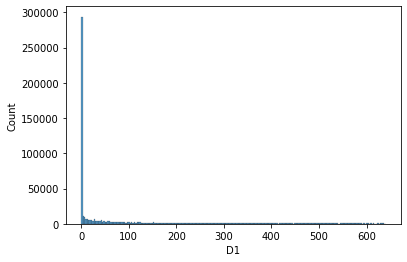

In [128]:
sns.histplot(x='D1', data=train);

시간 변화에 따른 D1의 분포가 좀 특이하다.

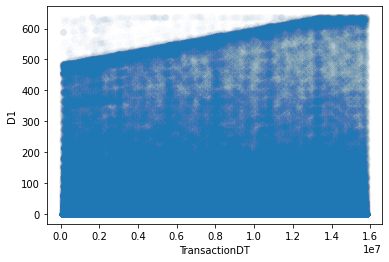

In [129]:
sns.scatterplot(x='TransactionDT', y='D1', edgecolor=None, alpha=.01, data=train);

이외에도 사용자 식별을 위해 다양한 column들을 조합하여 모델 학습에 활용해 보기로 하였다.

## Feature Engineering

EDA를 통해 얻은 정보들을 활용하여 feature engineering을 하였다.

In [130]:
del train, test

일치하지 않는 column 명을 수정하였다.

In [131]:
X_test.rename(
    dict(zip([col for col in X_test.columns if 'id' in col], [col for col in X_train.columns if 'id' in col])), 
    axis=1, 
    inplace=True
)

card1의 값을 이용하여 card2-card6의 결측값을 추론하여 채웠다.

In [132]:
card_cols = [col for col in X_train.columns if 'card' in col]

for card in card_cols[1:]:
    modes = {}

    for value in X_train['card1'].unique():
        try:
            modes[value] = X_train[X_train['card1'] == value][card].mode().values[0]

        except IndexError:
            pass
        
        
    for data in [X_train, X_test]:        
        na = set(data['card1'].unique()) - set(modes.keys())

        if len(na) > 0:
            for value in na:
                modes[value] = 'unknown' if data[card].dtype == object else -1

        values = []

        for x, y in zip(data['card1'], data[card]):
            values.append(modes[x] if type(y) == float and np.isnan(y) else y)

        data.loc[:, card] = values


del modes, na, values

TransactionDT가 초 단위라는 점, 시작일이 2017-12-01 라는 점, D9는 거래시각의 시 라는 점 등을 활용하여 다양한 feature들을 추가하였다. 거래 액수에서 소숫점 단위를 따로 분리하였다.

In [133]:
for data in [X_train, X_test]:
    data['TransactionDate'] = data['TransactionDT'].apply(lambda x: datetime.datetime.strptime('2017-11-30', '%Y-%m-%d') + datetime.timedelta(x/86400))
    data['TransactionMonth'] = data['TransactionDate'].apply(lambda x: x.month)
    data['TransactionDay'] = data['TransactionDT'] // 86400
    data['TransactionWeekday'] = data['TransactionDate'].apply(lambda x: x.weekday())
    data['D9'] = data['TransactionDate'].apply(lambda x: x.hour)
    data.drop(['TransactionDT', 'TransactionDate'], axis=1, inplace=True)
    data['cents'] = (data['TransactionAmt'] % 1).astype('float32')

    
X_train['TransactionMonth'] = X_train['TransactionMonth'].replace(12, 0)

categorical data를 numeric으로 변환하였다.

In [134]:
m_cols = [f'M{i}' for i in range(1,10)]

for data in [X_train, X_test]:
    for col in m_cols:
        if col != 'M4':
            data[col] = data[col].map({'T':1, 'F':0})

        else:
            data[col] = data[col].map({'M0':0, 'M1':1, 'M2':2})

In [138]:
for data in [X_train, X_test]:
    
    for col in ['id_12', 'id_15', 'id_16', 'id_27', 'id_28', 'id_29']:
        data[col] = data[col].fillna(-1).map({'New':2, 'Found':1, 'NotFound':0, 'unknown':-1, 'Unknown':-1})
    
    #data['id_33'] = data['id_33'].apply(lambda x: x if type(x) == float else eval(x.replace('x', '*')))
    
    data['id_34'] = data['id_34'].fillna(-1).map({'match_status:2':3, 'match_status:1':2, 'match_status:0':1, 'match_status:-1':0, 'unknown':-1})
    
    for col in ['id_35', 'id_36', 'id_37', 'id_38']:
        data[col] = data[col].fillna(-1).map({'T':1, 'F':0, 'unknown':-1})

feature의 수를 줄이기 위해 차원 축소를 포함한 여러가지 방법을 시도 해봤는데, 그 방법 중 하나로 상관계수를 이용하여 유사한 column을 제거하는 방법을 생각해보았다.

In [135]:
def column_to_drop(data, cols, thresh=0.7, verbose=0, how='gmean'):
    corr = data[cols].corr().abs()
    to_drop = []
    
    corrs = corr.abs().unstack().sort_values().reset_index()
    corrs = corrs[corrs['level_0'] < corrs['level_1']]
    corrs = corrs[corrs[0] > thresh].sort_values('level_0')
    
    pairs = corrs[['level_0', 'level_1']].values.tolist()

    for pair in pairs:
        if how == 'gmean':
            to_drop.append(pd.DataFrame(gmean(corr.loc[pair], axis=1), index=pair).sort_values(0).index[1])
        elif how == 'nunique':
            if data[pair[0]].nunique() > data[pair[1]].nunique():
                to_drop.append(pair[1])
            else:
                to_drop.append(pair[0])

        else:
            raise ValueError
    
    if verbose:
        print('To use:', sorted(set(cols) - set(to_drop), key=lambda x: int(x[1:])))
        print('To drop:', sorted(set(to_drop), key=lambda x: int(x[1:])))
        print('')
    
    return list(set(to_drop))

In [136]:
column_drop = {
    'v_cols':False,
    'c_cols':False,
    'd_cols':False,
    'm_cols':False,
}

column_list = {
    'v_cols':[col for col in X_train.columns if 'V' in col],
    'c_cols':[f'C{i}' for i in range(1,15)],
    'd_cols':[f'D{i}' for i in range(1,16)],
    'm_cols':[f'M{i}' for i in range(1,10)],
}

In [137]:
if column_drop['v_cols']:
    
    isna = X_train[column_list['v_cols']].isna().sum()

    na_dict = {}
    
    for value in isna.unique():
        na_dict[value] = isna[isna == value].keys().to_list()

    for cols in na_dict.values():
        to_drop = column_to_drop(X_train, cols, thresh=0.9, verbose=1)
        X_train.drop(to_drop, axis=1, inplace=True)
        X_test.drop(to_drop, axis=1, inplace=True)

        
for idx, cols in enumerate(list(column_drop.values())[1:]):
    if cols:
        to_drop = column_to_drop(X_train, column_list.values[1:][idx], thresh=0.9, verbose=1)
        X_train.drop(to_drop, axis=1, inplace=True)
        X_test.drop(to_drop, axis=1, inplace=True)

개별 사용자를 구분하기 위한 일종의 uid를 만들어 보았다.

In [139]:
for data in [X_train, X_test]:
    data['card1_addr1'] = data['card1'].fillna('na').astype(str) + '_' + data['addr1'].fillna('na').astype(str)
    data['card1_addr1_P_emaildomain'] = data['card1_addr1'] + '_' + data['P_emaildomain'].fillna('na')
    data['card1_addr1_D1'] = data['card1_addr1'] + '_'  + (data['TransactionDay']-data['D1']).astype(str)

일부 column에 대하여 label encoding 대신 frequency encoding을 활용하였다.

In [140]:
freq_cols = [
    'addr1','card1','card2','card3','P_emaildomain', 'card1_addr1',
    'card1_addr1_P_emaildomain', 'card1_addr1_D1'
]

In [141]:
for col in freq_cols:
    replace = pd.concat([X_train[col], X_test[col]]).value_counts().to_dict()
    
    for data in [X_train, X_test]:
        data[f'{col}_freq'] = data[col].map(replace)


del replace

gc.collect()

0

일부 feature들을 uid별로 묶어서 평균 및 표준편차를 구하여 column에 추가하였다.

In [142]:
cols = ['TransactionAmt','D9']
uids = ['card1', 'card1_addr1', 'card1_addr1_P_emaildomain', 'card1_addr1_D1']
metrics = ['mean', 'std']

for uid in uids:
    group = pd.concat([X_train[cols+[uid]], X_test[cols+[uid]]]).groupby(uid).agg(metrics)
    
    for data in [X_train, X_test]:
        for col in cols:
            for metric in metrics:
                data[f'{uid}_{col}_{metric}'] = data[uid].map(group.loc[:,(col, metric)].to_dict()).astype('float32')
                

#        data.drop(uid, axis=1, inplace=True)

del group

gc.collect()

15

categorical data를 label encoding 하였다.

In [143]:
obj_cols = [
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo', 
    'id_13', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_30', 'id_31', 'id_32', 'id_33',
    'card1_addr1', 'card1_addr1_P_emaildomain', 'card1_addr1_D1'
]


for feature in obj_cols:
    k, v = pd.concat([X_train[feature], X_test[feature]]).factorize(sort=True)
    
    X_train[feature] = X_train[feature].map(dict(zip(v,k)))
    X_test[feature] = X_test[feature].map(dict(zip(v,k)))
    

del k, v
gc.collect()

0

### Train Model

In [144]:
y_train = pd.DataFrame(X_train['isFraud']).astype('uint8').reset_index(drop=True)
X_train = X_train.drop('isFraud', axis=1)

Min max scale을 통해 데이터셋을 0-1 사이의 값으로 변환한 후, 결측값에 -1 값을 부여하였다.

In [145]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [146]:
X_train.fillna(-1,inplace=True)
X_test.fillna(-1,inplace=True)

파일 용량이 큰 관계로 메모리 부족 현상이 발생하여 각 column의 data type을 변경하여 용량을 축소하였다.

In [147]:
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [148]:
X_train = reduce_mem_usage2(X_train)
X_test = reduce_mem_usage2(X_test)

Memory usage of dataframe is 2081.52 MB
Memory usage after optimization is: 520.38 MB
Decreased by 75.0%
Memory usage of dataframe is 1785.97 MB
Memory usage after optimization is: 446.49 MB
Decreased by 75.0%


각각의 column들이 정말로 유효한지 검증하기 위해, 각 column들을 1개씩만 활용하여 모델을 학습시킨 후, 일정 수준 이상의 점수를 기록한 column만 활용하기로 하였다. 훈련은 train set에서 시간 순서상 가장 이른 달의 데이터를 이용하고, validation은 가장 늦은 달의 데이터를 활용하였다.

In [149]:
validate = False

In [150]:
if validate:
    train_idx = X_train[X_train['TransactionMonth'] == 0].index
    valid_idx = X_train[X_train['TransactionMonth'] == 1].index

    col_dict = {}

    thresh = 0.5

    for col in X_train.columns:
        try:
            clf = xgb.XGBClassifier(
                n_estimators=2000,
                max_depth=12, 
                learning_rate=0.02, 
                subsample=0.8,
                colsample_bytree=0.4, 
                verbosity=0, 
                missing=-1, 
                eval_metric='auc',
                tree_method='gpu_hist'
            )

            h = clf.fit(
                pd.DataFrame(X_train[col].loc[train_idx]), y_train.loc[train_idx], 
                eval_set=[(pd.DataFrame(X_train[col].loc[valid_idx]), y_train.loc[valid_idx])],
                verbose=0, early_stopping_rounds=100
            )

            col_dict[col] = np.mean(list(h.evals_result_.values())[0]['auc'])

        except OSError:
            col_dict[col] = 0
            
    valid_score = pd.DataFrame(col_dict, index=['auc']).T.reset_index()
    cols = valid_score[valid_score['auc'] > thresh]['index'].to_list()

else:
    cols = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
       'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1',
       'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V15', 'V16', 'V17', 'V18', 'V20', 'V21', 'V22',
       'V23', 'V24', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35',
       'V36', 'V37', 'V38', 'V39', 'V40', 'V42', 'V43', 'V44', 'V45',
       'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54',
       'V56', 'V57', 'V58', 'V59', 'V60', 'V62', 'V63', 'V64', 'V69',
       'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78',
       'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87',
       'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98',
       'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106',
       'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115',
       'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123',
       'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131',
       'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V139', 'V140',
       'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150',
       'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158',
       'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171',
       'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179',
       'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187',
       'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195',
       'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203',
       'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211',
       'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219',
       'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227',
       'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235',
       'V236', 'V237', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243',
       'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251',
       'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259',
       'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267',
       'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275',
       'V276', 'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283',
       'V284', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293',
       'V294', 'V295', 'V296', 'V298', 'V299', 'V300', 'V301', 'V302',
       'V303', 'V304', 'V306', 'V307', 'V308', 'V309', 'V310', 'V312',
       'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V320', 'V321',
       'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23',
       'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_31',
       'id_35', 'id_36', 'id_37', 'DeviceType', 'DeviceInfo',
       'TransactionWeekday', 'cents', 'card1_addr1',
       'card1_addr1_P_emaildomain', 'card1_addr1_D1', 'addr1_freq',
       'card1_freq', 'card2_freq', 'card3_freq', 'P_emaildomain_freq',
       'card1_addr1_freq', 'card1_addr1_P_emaildomain_freq',
       'card1_addr1_D1_freq', 'card1_TransactionAmt_mean',
       'card1_TransactionAmt_std', 'card1_D9_mean', 'card1_D9_std',
       'card1_addr1_TransactionAmt_mean',
       'card1_addr1_TransactionAmt_std', 'card1_addr1_D9_mean',
       'card1_addr1_D9_std',
       'card1_addr1_P_emaildomain_TransactionAmt_mean',
       'card1_addr1_P_emaildomain_TransactionAmt_std',
       'card1_addr1_P_emaildomain_D9_mean',
       'card1_addr1_P_emaildomain_D9_std',
       'card1_addr1_D1_TransactionAmt_mean',
       'card1_addr1_D1_TransactionAmt_std', 'card1_addr1_D1_D9_mean',
       'card1_addr1_D1_D9_std']

In [151]:
np.array(cols)

array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
       'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1',
       'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V15', 'V16', 'V17', 'V18', 'V20', 'V21', 'V22',
       'V23', 'V24', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35',
       'V36', 'V37', 'V38', 'V39', 'V40', 'V42', 'V43', 'V44', 'V45',
       'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54',
       'V56', 'V57', 'V58', 'V59', 'V60', 'V62', 'V63', 'V64', 'V69',
       'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78',
       'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87',
       '

모델 훈련 시에도 시간 상 앞쪽에 위치한 데이터를 train set, 뒤쪽에 위치한 데이터를 valid set으로 활용하였다. cross validation 으로는 group k fold를 사용하였는데, 그룹은 Transaction month를 기준으로 나누었다.

In [ ]:
%%time

oof = np.zeros(len(X_train))
preds = np.zeros(len(X_test))

q3 = 3*len(X_train)//4
train_idx = X_train.index[:q3]
valid_idx = X_train.index[q3:]

skf = GroupKFold(n_splits=6)
for i, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train, groups=X_train['TransactionMonth']) ):
    month = X_train.iloc[valid_idx]['TransactionMonth'].iloc[0]
    
    clf = xgb.XGBClassifier(
        n_estimators=5000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        verbosity=0,
        eval_metric='auc',
        tree_method='gpu_hist'
        )        

    h = clf.fit(
        X_train[cols].iloc[train_idx], y_train.iloc[train_idx], 
        eval_set=[(X_train[cols].iloc[valid_idx],y_train.iloc[valid_idx])],
        verbose=100, early_stopping_rounds=200
        )

    oof[valid_idx] += clf.predict_proba(X_train[cols].iloc[valid_idx])[:,1]
    preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
    del h, clf
    x=gc.collect()



print ('Mean auc:',roc_auc_score(y_train,oof))

In [153]:
sample_submission = pd.read_csv(path+'sample_submission.csv')
sample_submission['isFraud']= preds
sample_submission.to_csv('sub.csv',index=False)

![image info](res.png)

기록한 가장 높은 public score는 0.950552 이며, 이 때의 private score는 0.924592였다. public score 기준으로는 상위 29.06% 이며, private score 기준으로는 상위 24.70% 이다.